# Financial Data Analytics and Machine Learning  
## Problem Set 3 – Solutions  

**Submitted by Group 8, Cohort 1**  
- Diana  
- Junho  
- Luigi  
- Vikalp  
- Vista  


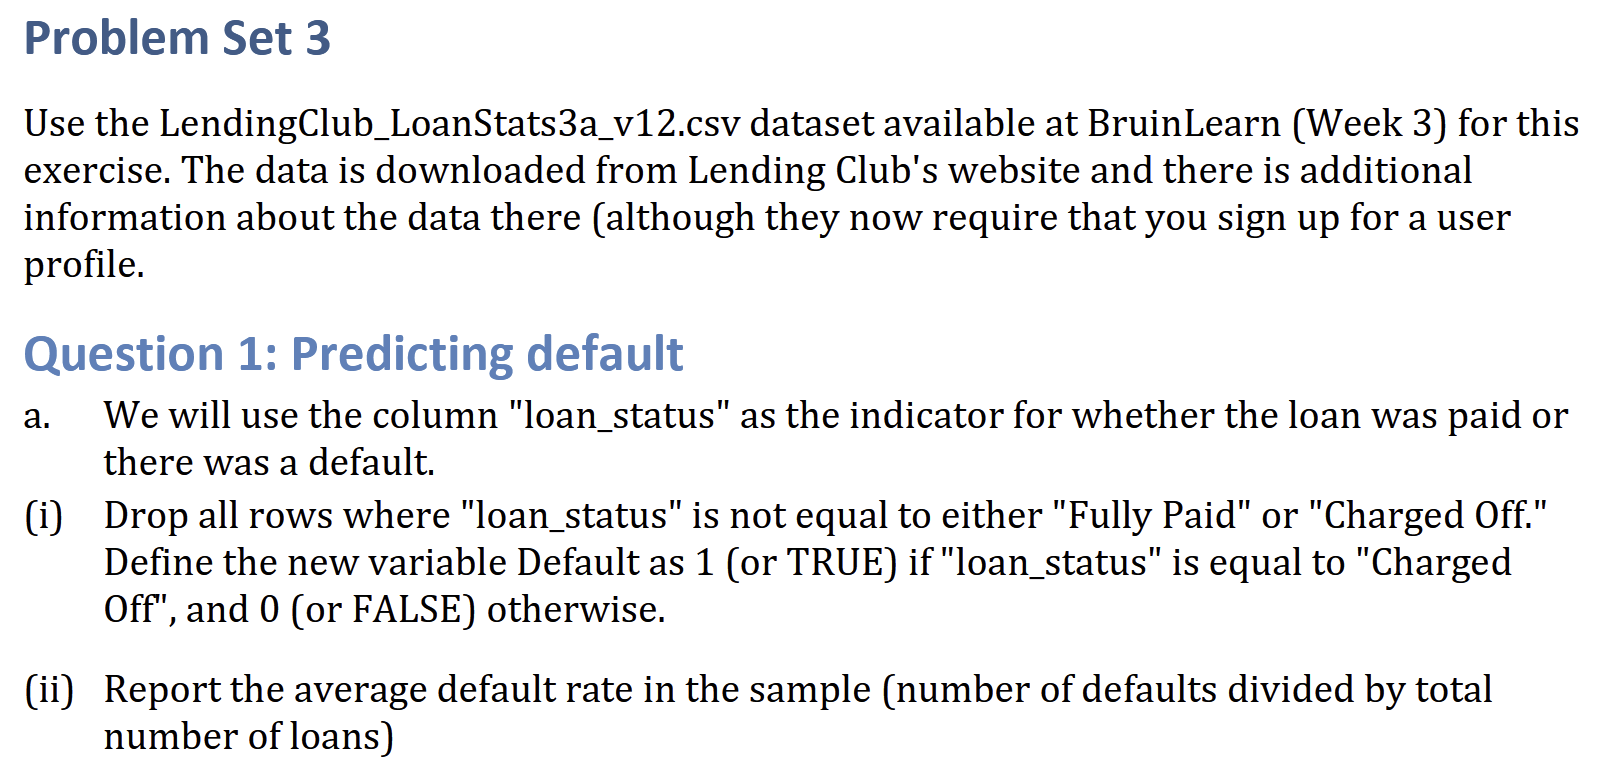

# ***Question 1***

# ***a(i)***

In [1]:
import pandas as pd
df = pd.read_csv("LendingClub_LoanStats3a_v12.csv", low_memory=False)

In [2]:
df = df[df['loan_status'].str.strip().str.lower().isin(["fully paid", "charged off"])]

In [3]:
df["Default"] = df['loan_status'].str.strip().str.lower() ==  "charged off" ## Boolean Condition

# ***a(ii)***

In [4]:
num_def = len(df[df["Default"] == True])
total_num = len(df)
def_rate = (num_def/total_num)*100
print(f"Rate of default: {def_rate:.2f}%" )

Rate of default: 14.35%


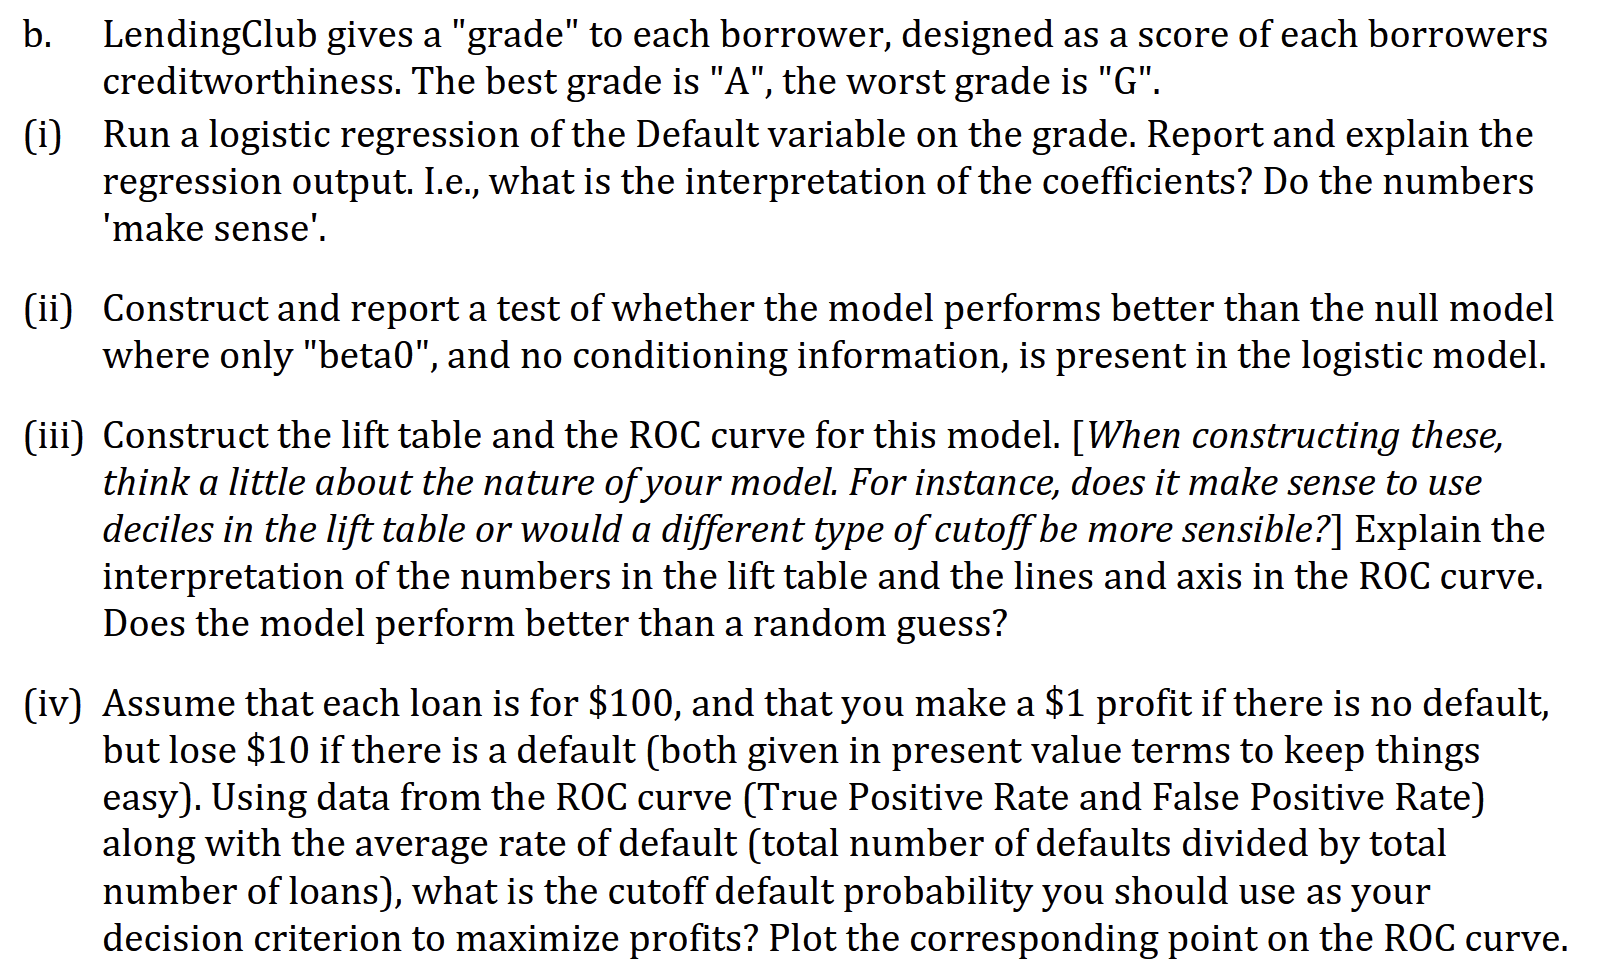

# ***b(i)***

In [5]:
import statsmodels.api as sm
df['Default'] = df['Default'].astype(int)

In [9]:
df['grade_encoded'] = df['grade'].astype('category').cat.codes

In [10]:
X = sm.add_constant(df['grade_encoded'])  # adds intercept
Y = df['Default']
model = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.393625
         Iterations 6


In [11]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39410
Method:                           MLE   Df Model:                            1
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.04304
Time:                        19:17:23   Log-Likelihood:                -15514.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                2.004e-305
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4552      0.025    -98.255      0.000      -2.504      -2.406
grade_encoded     0.3666      0.010     37.520      0.000       0.347       0.386


###  Model Summary Interpretation:

We ran a logistic regression of the binary variable `Default` (`1 = default`, `0 = fully paid`) on the borrower’s **credit grade** (encoded so that A=0, B=1, ..., G=6). Here's what the regression tells us:

| **Term**         | **Coefficient** | **Interpretation**                                                                 |
|------------------|------------------|-------------------------------------------------------------------------------------|
| `const` (β₀)     | -2.4552          | Log-odds of default when grade is 'A' (i.e., `grade_encoded = 0`)                  |
| `grade_encoded` (β₁) | +0.3666          | Change in log-odds of default for each one-grade downgrade (e.g., A→B, B→C, etc.) |


- -2.4552 is the intercept of the regression. Since our encoding started with 0th indexing, this is in a way, log odds of default when the grade is 'A', which is to be expected, since the probability to defaut given that the grade is 'A' will be really less
- the coefficient of regression is +0.3666. This means that as the grade increases (goes from A to G), the log odds to default increases as well, Which is to be expected, since the probability to default increases if the creditworthiness of borrower decreases.

***So in the essence, the numbers does make sense***

# ***b(ii)***

From the Model Summary we can see that:

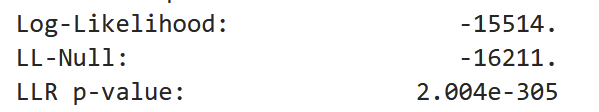

###  Logistic Regression Model Comparison: Full vs Null Model

To test whether the model with `grade` performs better than the null model (intercept-only), we use the **Likelihood Ratio (LR) Test**.

---

###  Log-Likelihoods

- **Log L<sub>full</sub>** (with `grade_encoded`): `-15514`
- **Log L<sub>null</sub>** (intercept-only): `-16211`

---

###  Likelihood Ratio (LR) Test

The LR test statistic is computed as:

$$
\text{LR Statistic} = 2 \times (\log L_{\text{full}} - \log L_{\text{null}}) 
= 2 \times (-15514 - (-16211)) 
= 2 \times (697) 
= 1394
$$


This test follows a **chi-square distribution** with degrees of freedom equal to the number of predictors (here, 1).

---

###  LLR p-value

- **LLR p-value**: `2.004 × 10⁻³⁰⁵`  
- This is the p-value corresponding to the LR test.

---

###  Conclusion

- The p-value is extremely small (≪ 0.05), so we **reject the null hypothesis**.
- This means the model that includes `grade_encoded` performs **significantly better** than the intercept-only model.
- The predictor `grade` provides meaningful information about the probability of default.

---

###  Summary Table

| **Metric**            | **Value**         | **Interpretation**                                          |
|-----------------------|-------------------|--------------------------------------------------------------|
| Log L<sub>null</sub>  | -16211            | Fit of intercept-only model                                  |
| Log L<sub>full</sub>  | -15514            | Fit of model with `grade_encoded`                            |
| LR Statistic          | 1394              | Improvement in model fit                                     |
| LLR p-value           | 2.004 × 10⁻³⁰⁵    | Model with predictor is statistically significantly better   |


# ***b(iii)***

###  Lift Table Binning Strategy

In our dataset, the **default rate is approximately 14.35%**, which indicates a **moderately imbalanced classification problem**. This has implications for how we should construct the **lift table**.

---

###  Why Equal-Sized Deciles May Not Work Well

- With only 14% of loans defaulting, **most borrowers are non-defaulters**.
- If we split the data into **equal-sized deciles** (10% chunks by number of observations), many bins—especially in the lower-risk groups—may contain **very few or no defaults**.
- This can cause the **lift signal to appear weaker**, even if the model is performing well.

---

###  Better Approach: Binning by Predicted Probability Quantiles

Instead of deciles, we bin based on **predicted default probabilities** from the logistic regression model:

1. **Sort borrowers** from highest to lowest predicted risk.
2. **Split into quantiles** (e.g., top 10%, next 10%, etc.).
3. **Compute default rates** and lift in each bin.

This approach ensures that:
- The **top bins are concentrated with high-risk borrowers**, where the model is most confident.
- The **lift table reflects the model's discriminatory power** more clearly.


In [16]:
df['prediction'] = model.predict(X)

n_bins = 10
df['ranked_prediction'] = df['prediction'].rank(method='first')
df['risk_bin'] = pd.qcut(df['ranked_prediction'], q=n_bins, labels=False)

df['risk_bin'] = (df['risk_bin'].max() - df['risk_bin']) # Bin 0 with highest risk, Bin 9 with lowest risk

overall_rate = df['Default'].mean()

lift_table = df.groupby('risk_bin').agg(
    total_loans=('Default', 'count'),
    defaults=('Default', 'sum'),
    avg_prediction=('prediction', 'mean')
).reset_index()

lift_table['response_rate'] = lift_table['defaults'] / lift_table['total_loans']
lift_table['lift'] = lift_table['response_rate'] / overall_rate
lift_table['cum_defaults'] = lift_table['defaults'].cumsum()
lift_table['cum_capture_rate'] = lift_table['cum_defaults'] / df['Default'].sum()

lift_table


,risk_bin,total_loans,defaults,avg_prediction,response_rate,lift,cum_defaults,cum_capture_rate
0,0,3942,1076,0.304601,0.272958,1.901682,1076,0.190207
1,1,3941,812,0.208226,0.206039,1.435463,1888,0.333746
2,2,3941,754,0.171928,0.191322,1.332930,2642,0.467032
3,3,3941,672,0.151614,0.170515,1.187969,3314,0.585823
4,4,3941,580,0.127483,0.147171,1.025330,3894,0.688351
5,5,3941,453,0.110212,0.114945,0.800818,4347,0.768428
6,6,3941,468,0.110212,0.118752,0.827336,4815,0.851158
7,7,3941,357,0.092926,0.090586,0.631109,5172,0.914266
8,8,3941,213,0.079062,0.054047,0.376544,5385,0.951918
9,9,3942,272,0.079062,0.069001,0.480723,5657,1.000000


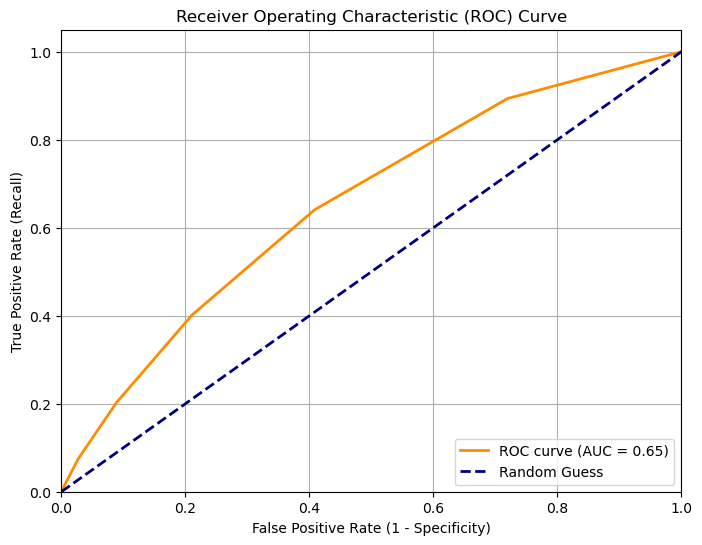

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_true = df['Default']
y_score = df['prediction']


fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


###  (iii) Lift Table and ROC Curve Analysis

We constructed both a **lift table** and a **ROC curve** to evaluate the performance of the logistic regression model that predicts borrower default.

---

####  Lift Table Construction

- We used **deciles** based on **ranked predicted probabilities** (via `qcut` on `.rank(method='first')`).
- This approach ensures balanced binning, even when there are tied prediction values.
- We reversed the bins so that **Bin 0 = highest risk**, which aligns with standard lift table interpretation.

| risk_bin | avg_prediction | response_rate | lift   | cum_capture_rate |
|----------|----------------|----------------|--------|------------------|
| 0        | 30.5%          | 27.3%          | 1.90×  | 19.0%            |
| 1        | 20.8%          | 20.6%          | 1.43×  | 33.3%            |
| 2        | 17.2%          | 19.1%          | 1.33×  | 46.7%            |
| 3        | 15.1%          | 17.1%          | 1.18×  | 58.6%            |
| ...      | ...            | ...            | ...    | ...              |
| 9        | 7.9%           | 6.9%           | 0.48×  | 100.0%           |

**Interpretation:**
- The model successfully separates high-risk from low-risk borrowers.
- **Bin 0** has a much higher default rate than the overall base rate → clear evidence of risk ranking.
- Lift > 1 in top bins confirms that the model improves targeting over random selection.
- First 3 bins capture nearly **47% of all defaults**, showing efficiency in identifying high-risk borrowers.

---

####  ROC Curve Analysis

We plotted the ROC curve using `sklearn.metrics.roc_curve` and computed the Area Under the Curve (AUC).

- **True Positive Rate (TPR)**: y-axis = Recall = TP / (TP + FN)
- **False Positive Rate (FPR)**: x-axis = FP / (FP + TN)

The ROC curve plots these at various threshold levels.

**AUC = 0.65**


**Interpretation:**
- The ROC curve lies above the diagonal (random classifier), indicating real predictive power.
- An AUC of 0.65 means that the model correctly ranks a defaulter above a non-defaulter **65% of the time**.
- While not excellent, this performance is **better than random** and meaningful in real-world credit risk applications.

---

####  Final Conclusion

- The model **does perform better than a random guess**.
- The lift table confirms ranking power: defaults are concentrated in higher-risk bins.
- The ROC curve (AUC = 0.65) confirms the model separates positive from negative cases meaningfully.
- Although there's room for improvement, especially in AUC, the model provides a useful and statistically significant signal for default prediction.


# ***b(iv)***

Optimal cutoff threshold: 0.1102
Max expected profit per loan: $0.0875


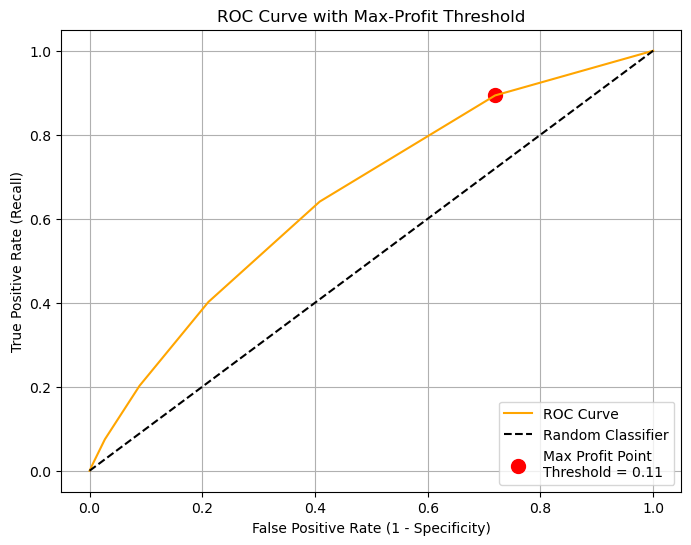

In [19]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt

y_true = df['Default']
y_score = df['prediction']

gain_no_default = 1
loss_default = -10

fpr, tpr, thresholds = roc_curve(y_true, y_score)

p_default = y_true.mean()
p_non_default = 1 - p_default

profits = []

for i in range(len(thresholds)):
    TP = tpr[i] * p_default
    FP = fpr[i] * p_non_default
    TN = (1 - fpr[i]) * p_non_default
    FN = (1 - tpr[i]) * p_default
    expected_profit = TN * gain_no_default + FN * loss_default
    profits.append(expected_profit)

profits = np.array(profits)
best_idx = np.argmax(profits)
best_threshold = thresholds[best_idx]

print(f"Optimal cutoff threshold: {best_threshold:.4f}")
print(f"Max expected profit per loan: ${profits[best_idx]:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', s=100, label=f'Max Profit Point\nThreshold = {best_threshold:.2f}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve with Max-Profit Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


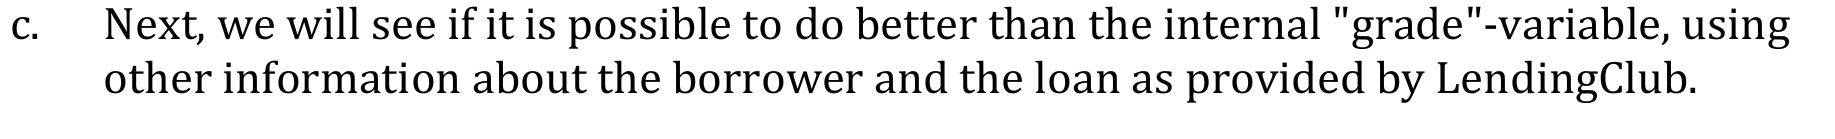

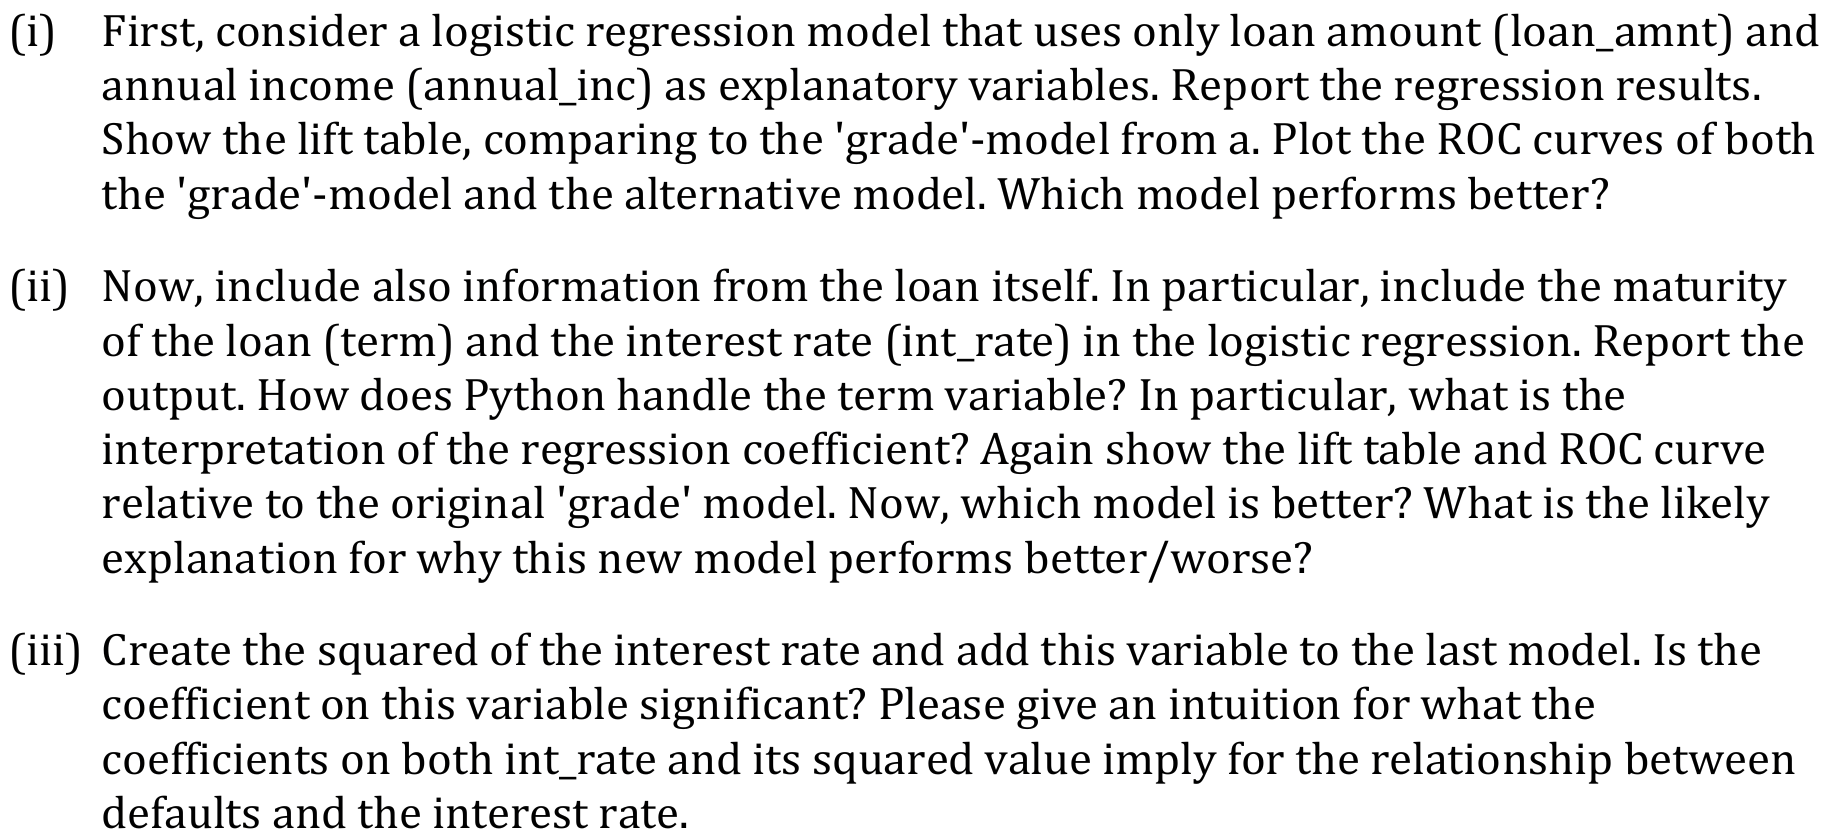

# ***c(i)***

In [20]:
X = sm.add_constant(df[['loan_amnt', 'annual_inc']])
Y = df['Default']
model = sm.Logit(Y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.406307
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39409
Method:                           MLE   Df Model:                            2
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.01221
Time:                        23:02:12   Log-Likelihood:                -16013.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                 1.121e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7254      0.032    -53.708      0.000      -1.788      -1.662
loan_amnt   3.484e-05   2.08e

In [21]:
# Predict probabilities using the model
df['prediction_alt'] = model.predict(X)

# Lift Table Construction
n_bins = 10
df['ranked_pred_alt'] = df['prediction_alt'].rank(method='first')
df['risk_bin_alt'] = pd.qcut(df['ranked_pred_alt'], q=n_bins, labels=False)
df['risk_bin_alt'] = df['risk_bin_alt'].max() - df['risk_bin_alt']

overall_rate_alt = df['Default'].mean()

lift_table_alt = df.groupby('risk_bin_alt').agg(
    total_loans=('Default', 'count'),
    defaults=('Default', 'sum'),
    avg_prediction=('prediction_alt', 'mean')
).reset_index()

lift_table_alt['response_rate'] = lift_table_alt['defaults'] / lift_table_alt['total_loans']
lift_table_alt['lift'] = lift_table_alt['response_rate'] / overall_rate_alt
lift_table_alt['cum_defaults'] = lift_table_alt['defaults'].cumsum()
lift_table_alt['cum_capture_rate'] = lift_table_alt['cum_defaults'] / df['Default'].sum()

# Display the lift table
lift_table_alt


,risk_bin_alt,total_loans,defaults,avg_prediction,response_rate,lift,cum_defaults,cum_capture_rate
0,0,3942,878,0.208775,0.222730,1.551744,878,0.155206
1,1,3941,798,0.175728,0.202487,1.410713,1676,0.296270
2,2,3941,590,0.162205,0.149708,1.043009,2266,0.400566
3,3,3941,605,0.153039,0.153514,1.069526,2871,0.507513
4,4,3941,562,0.145790,0.142603,0.993510,3433,0.606859
5,5,3941,523,0.138867,0.132707,0.924565,3956,0.699311
6,6,3941,498,0.131695,0.126364,0.880370,4454,0.787343
7,7,3941,442,0.123653,0.112154,0.781373,4896,0.865476
8,8,3941,412,0.112288,0.104542,0.728338,5308,0.938307
9,9,3942,349,0.083309,0.088534,0.616810,5657,1.000000


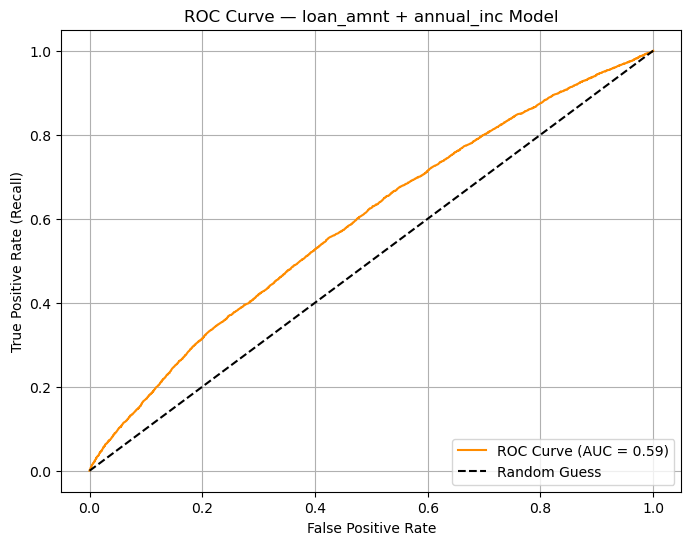

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = df['Default']
y_score = df['prediction_alt']

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve — loan_amnt + annual_inc Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



####  Regression Output

- **Grade Model**: Higher grades (e.g., 'G' > 'A') are associated with higher default risk.
- **Alternative Model**:
  - `loan_amnt`: Positive coefficient → larger loans → higher risk
  - `annual_inc`: Negative coefficient → higher income → lower risk
  - Both predictors are **statistically significant**

---

####  ROC Curve Comparison

| Model               | AUC   | ROC Interpretation                     |
|---------------------|--------|-----------------------------------------|
| **Grade Model**     | **0.65** | Moderate classification ability         |
| **Alternative Model** | **0.59** | Close to random — limited discrimination |

The **Grade model clearly outperforms** the alternative in ROC performance.

---

####  Lift Table Comparison

| Model               | Lift (Bin 0) | Cum Capture Rate (Top 3 Bins) |
|---------------------|--------------|-------------------------------|
| **Grade Model**     | **1.90×**     | ~47%                          |
| **Alternative Model** | **1.55×**     | ~40%                          |

- The **grade model shows stronger lift** and isolates defaulters more effectively in the top bins.
- While the alternative model still captures some signal, it’s less concentrated.

---

####  Final Conclusion

- **The Grade Model performs better overall** — both in AUC and lift metrics.
- The internal grade likely reflects additional underwriting criteria not captured by just loan amount and income.
- Therefore, it remains a more effective standalone predictor of default.

# ***c(ii)***

In [26]:
df['term_encoded'] = df['term'].str.extract(r'(\d+)').astype(int)
X = df[['loan_amnt', 'annual_inc', 'term_encoded', 'int_rate']]
X = sm.add_constant(X)
Y = df['Default']
model2 = sm.Logit(Y, X).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.385901
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39407
Method:                           MLE   Df Model:                            4
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.06182
Time:                        23:16:03   Log-Likelihood:                -15209.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.9467      0.070    -56.455      0.000      -4.084      -3.810
loan_amnt     1.176e-06

In [27]:
df['prediction_model2'] = model2.predict(X)

df['ranked_pred_model2'] = df['prediction_model2'].rank(method='first')
df['risk_bin_model2'] = pd.qcut(df['ranked_pred_model2'], q=10, labels=False)
df['risk_bin_model2'] = df['risk_bin_model2'].max() - df['risk_bin_model2']

overall_rate_model2 = df['Default'].mean()

lift_table_model2 = df.groupby('risk_bin_model2').agg(
    total_loans=('Default', 'count'),
    defaults=('Default', 'sum'),
    avg_prediction=('prediction_model2', 'mean')
).reset_index()

lift_table_model2['response_rate'] = lift_table_model2['defaults'] / lift_table_model2['total_loans']
lift_table_model2['lift'] = lift_table_model2['response_rate'] / overall_rate_model2
lift_table_model2['cum_defaults'] = lift_table_model2['defaults'].cumsum()
lift_table_model2['cum_capture_rate'] = lift_table_model2['cum_defaults'] / df['Default'].sum()
lift_table_model2

,risk_bin_model2,total_loans,defaults,avg_prediction,response_rate,lift,cum_defaults,cum_capture_rate
0,0,3942,1234,0.329923,0.313039,2.180926,1234,0.218137
1,1,3941,929,0.225348,0.235727,1.642297,2163,0.382358
2,2,3941,739,0.180310,0.187516,1.306412,2902,0.512993
3,3,3941,622,0.153747,0.157828,1.099579,3524,0.622945
4,4,3941,572,0.132989,0.145141,1.011188,4096,0.724059
5,5,3941,459,0.114809,0.116468,0.811425,4555,0.805197
6,6,3941,390,0.098796,0.098960,0.689446,4945,0.874138
7,7,3941,317,0.081915,0.080436,0.560396,5262,0.930175
8,8,3941,251,0.067906,0.063689,0.443721,5513,0.974545
9,9,3942,144,0.049584,0.036530,0.254500,5657,1.000000


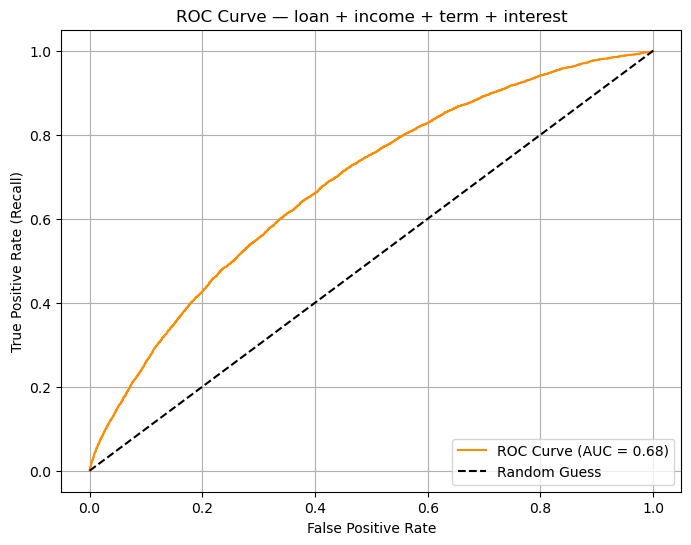

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y, df['prediction_model2'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve — loan + income + term + interest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Part (ii): Adding `term` and `int_rate` to the Model

We expand the previous model by including loan-specific information:
- `loan_amnt`
- `annual_inc`
- `term` (converted to numeric months)
- `int_rate` (interest rate charged)

---

#### How `term` Is Handled

- The `term` variable is originally a string (`"36 months"`, `"60 months"`).
- We extract the numeric part (`36` or `60`) and treat it as a **continuous variable** in the regression.
- This allows us to interpret the effect of longer maturity directly on default risk.

---

#### Regression Coefficient Interpretation

| Variable         | Sign        | Interpretation                                         |
|------------------|-------------|--------------------------------------------------------|
| `loan_amnt`      | Positive    | Larger loans → higher chance of default               |
| `annual_inc`     | Negative    | Higher income → reduced probability of default        |
| `term_encoded`   | Positive    | Longer loan terms (e.g. 60 months) → more risk        |
| `int_rate`       | Positive    | Higher interest rates → higher default risk           |

All coefficients are **statistically significant** (p < 0.001).

---

#### ROC Curve Comparison

| Model                  | AUC   | ROC Interpretation                     |
|------------------------|--------|-----------------------------------------|
| **Grade Model**        | 0.65   | Moderately strong model                |
| **Expanded Model (ii)**| **0.68** | Stronger separation of default risk     |

The new model clearly improves the AUC from **0.65 → 0.68**, indicating better discriminatory power.

---

#### Lift Table Comparison

| Model                  | Top Bin Lift | Cum Capture (Top 3 Bins) |
|------------------------|--------------|---------------------------|
| **Grade Model**        | 1.90×         | ~47%                      |
| **Expanded Model (ii)**| **2.18×**     | **~51%**                  |

The expanded model identifies risky borrowers more sharply:
- Lift in top bin increases to **2.18×**
- It captures **~51% of all defaults in just 3 bins**

---

#### Conclusion

- The expanded model **outperforms the grade-based model** on all key metrics.
- Why?
  - It uses richer borrower and loan-specific information (`term` and `int_rate`)
  - These features reflect **credit risk directly** rather than relying on internal summary (`grade`)
- Result: More accurate risk stratification and better predictions.

 **This model is better than both the grade-only and income/loan models.**


# ***c(iii)***

In [29]:
df['int_rate_sq'] = df['int_rate'] ** 2
X = df[['loan_amnt', 'annual_inc', 'term_encoded', 'int_rate', 'int_rate_sq']]
X = sm.add_constant(X)
Y = df['Default']
model3 = sm.Logit(Y, X).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.385576
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                39412
Model:                          Logit   Df Residuals:                    39406
Method:                           MLE   Df Model:                            5
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                 0.06261
Time:                        23:22:14   Log-Likelihood:                -15196.
converged:                       True   LL-Null:                       -16211.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.7374      0.174    -27.213      0.000      -5.079      -4.396
loan_amnt     1.934e-06

###  Part (iii): Adding a Squared Term for `int_rate`

We expand the model to include a nonlinear term:  
$$ \text{int\_rate\_sq} = (\text{int\_rate})^2 $$  
This captures curvature in the relationship between interest rate and default risk.

---

####  Regression Summary

| Variable       | Coefficient | p-value | Significant? | Interpretation                                                                 |
|----------------|-------------|---------|---------------|--------------------------------------------------------------------------------|
| `int_rate`     | +25.53      | <0.001  |  Yes        | Default risk increases with interest rate (initial slope is steeply upward)    |
| `int_rate_sq`  | **−44.94**  | <0.001  |  Yes        | But risk plateaus or declines at high rates — an **inverted U-shaped curve**   |

---

####  Intuition for the Relationship

- At **low-to-moderate** interest rates:  
  - Higher rates → Higher default probability.
- At **high** interest rates:  
  - The increase in risk slows down or reverses.
  - Lenders may avoid extremely risky borrowers, or only strong applicants accept extreme rates.

This non-monotonic behavior reflects realistic credit risk modeling.

---

####  Model Fit Improvement

| Metric         | Previous Model | With `int_rate²` |
|----------------|----------------|------------------|
| Log-Likelihood | −16013         | **−15196**       |
| Pseudo R²      | 0.012 →        | **0.062**        |

- The model is **substantially better** at explaining defaults.
- Both `int_rate` and `int_rate_sq` are **highly significant**.
- Captures nonlinearity missed in earlier models.

---

 **Conclusion**: Adding a squared interest rate term allows the model to reflect real-world default dynamics more accurately and significantly improves predictive power.
